<a href="https://colab.research.google.com/github/changsin/Sidewalk/blob/main/notebooks/EDA_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA for the dashboard dataset 

## Setup
Install requirements and prepare the dataset for training.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_ROOT = "/content/drive/MyDrive/data/Dashboard/Top15/"

In [4]:
import glob
import os

def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths


In [5]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
  files = glob_files(path, "*.jpg")

  # print(files)
  X_data = []
  for file in files:
    image = cv2.imread(file)
    image = image/255
    # print(image.shape)
    # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    X_data.append(image)
  return np.array(X_data)

In [6]:
X = load_images(DATA_ROOT + "train/train_top15_0/")
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(80,)

In [7]:
# WIDTH = 1920
# HEIGHT = 1080

def load_labels(path, X):
  files = glob_files(path, "*.txt")

  Y_data = []
  for file, x in zip(files, X):
    width = x.shape[1]
    height = x.shape[0]
    with open(file) as f:
      lines = f.readlines()

      boxes = []
      for line in lines:
        tokens = line.split()

        class_id = int(tokens[0])
        xc = float(tokens[1]) * width
        yc = float(tokens[2]) * height
        box_width = float(tokens[3]) * width
        box_height = float(tokens[4]) * height

        boxes.append(np.array([class_id, xc, yc, box_width, box_height]))
        # print(class_id, xc, yc, width, height)

      Y_data.append(np.array(boxes))
      # print(lines)
  return np.array(Y_data)

Y = load_labels(DATA_ROOT + "train/train_top15_0/", X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [39]:
COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

CLASS_NAMES = [ "alert@Alternator", "alert@Brake", "alert@Coolant",
                "alert@Distance", "alert@EngineOil", "alert@EngineOilTemp",
                "alert@Parking", "alert@Retaining", "alert@Seatbelt",
                "alert@Steering",

                "warning@ABS", "warning@Brake", "warning@BrakeWear",
                "warning@CentralMonitoring", "warning@EPC", "warning@Engine",
                "warning@Fuel", "warning@Glow", "warning@Headlamp",
                "warning@Lamp", "warning@Parking", "warning@Retaining",
                "warning@StabilityOff", "warning@StabilityOn", "warning@Steering",
                "warning@TPMS", "warning@Tire", "warning@Washer"]

DB_EXCLUDE = [
    "warning@Retaining",
    "warning@Steering",
    "alert@EngineOilTemp",
    "warning@Glow",
    "warning@CentralMonitoring",
    "warning@EPC",
    "warning@Washer"
]

DB_TOP15 = [
    # Top 5
    "alert@Seatbelt",
    "warning@Engine",
    "alert@Parking",
    "warning@Tire",
    "warning@StabilityOn",

    # Top 10
    "alert@Brake",
    "warning@StabilityOff",
    "warning@Brake",
    "alert@Steering",
    "warning@Parking",

    # Top 15
    "alert@Retaining",
    "alert@Distance",
    "warning@ABS",
    "alert@Coolant",
    "warning@Fuel"
]

DB_TOP5 = DB_TOP15[:5]
DB_TOP10 = DB_TOP15[5:10]
DB_TOP15 = DB_TOP15[10:15]

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_patch_rectangle(y, color=COLORS[2]):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

def plot_label_images(X, Y, limit=10):
  fig = plt.figure(figsize=(10, 8))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.set_title(CLASS_NAMES[Y[id]])
    axis.imshow(X[id])
  fig.show()

def get_bbox(y):
  width = int(y[2])
  height = int(y[3])
  return int(y[0] - width/2), int(y[1] - height/2), width, height

def plot_labels(X, Y, limit=30):
  fig = plt.figure(figsize=(10, 8))
  last_id = min(limit, X.shape[0])

  print(last_id, limit, X.shape[0])

  label_id = 1
  for id in range(last_id):

    image = X[id]
    for box in Y[id]:
      if label_id >= 100:
        break

      class_id = int(box[0])
      x, y, box_width, box_height = get_bbox(box[1:])
      # print("y:", y, y + box_height, "x:", x, x + box_width)
      # print(image[y:y+box_height, x:x+box_width].shape)

      axis = fig.add_subplot(10, 10, label_id)
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(image[y:y+box_height, x:x+box_width])

      axis.show()
      label_id += 1

LABEL_SIZE = 20
def extract_box_image_data(X, Y):
  box_images = []
  box_labels = []
  for id in range(len(X)):
    image = X[id]
    for box in Y[id]:
      class_id = int(box[0])
      box_labels.append(class_id)

      x, y, box_width, box_height = get_bbox(box[1:])
      box_image = image[y:y+box_height, x:x+box_width]
      # Make sure that you resize all labels.
      # This is necessary for two reasons:
      #   1. If image sizes are different,
      #      the resulting box_images will not be a whole sum np.array.
      #     Instead, it will become an array of arraies
      #   2. For clustering purposes
      box_image = cv2.resize(box_image, (IMAGE_SIZE, IMAGE_SIZE))
      box_images.append(box_image)

  box_images = np.array(box_images)
  box_labels = np.array(box_labels)
  return box_images, box_labels
# plot_images(np.array(X[:1]), np.array(Y[:1]))

In [10]:
# plot_labels(np.array(X[:50]), np.array(Y[:50]), limit=50)

box_images, box_labels = extract_box_image_data(X, Y)

In [11]:
box_labels.shape
box_images.shape

(323, 600, 600, 3)

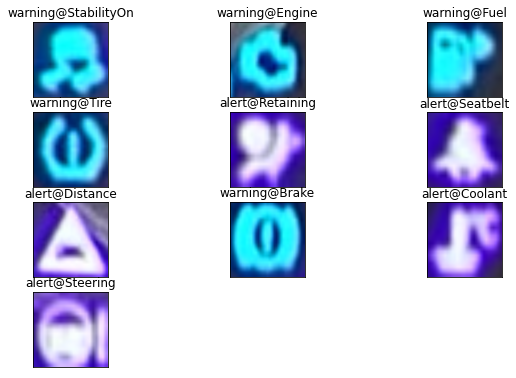

In [12]:
plot_label_images(box_images, box_labels)

In [13]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist

from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def to_feature_maps(X):
  #Convert to VGG input format
  # This is not necessary since the input is already normalized when loading
  # X_processed = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  return model.predict(X)

def get_pca_reduced(X_fm, dimensions=2):
  X_fm_flat = X_fm.reshape(X_fm.shape[0], -1)
  pca = PCA(dimensions)

  X_fm_reduced = pca.fit_transform(X_fm_flat)

  return X_fm_reduced, pca


def get_clusters(X, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(X, K=2):
  # make it 2D
  X_reshaped = preprocessing.normalize(X.reshape(len(X), -1))
  X_clusters, kmeans = get_clusters(X_reshaped, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  # return X_reshaped, kmeans
  return X_reshaped, X_clusters, kmeans

def cluster_images_fm(X, K=2, cosine_distance=True):
  X_fm = to_feature_maps(X)

  # # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  X_clusters_fm, kmeans_fm = get_clusters(X_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_fm, X_clusters_fm, kmeans_fm

In [14]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING/2
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("KMeans clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

## Cluster two classes

In [15]:
idx_a_seatbelt = np.where(CLASS_NAMES.index('alert@Seatbelt') == box_labels)
idx_a_parking = np.where(CLASS_NAMES.index('alert@Parking') == box_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


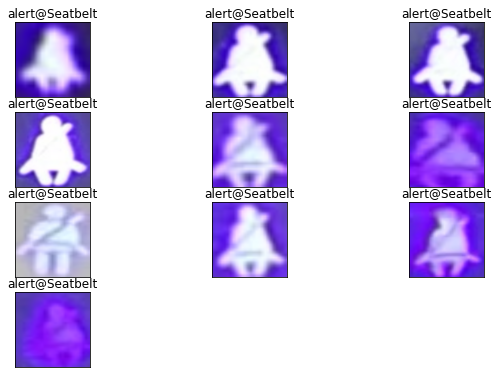

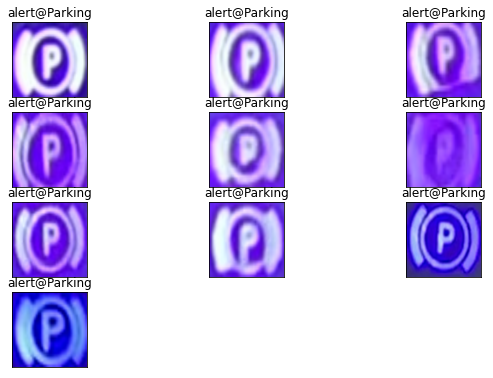

In [16]:
box_images[idx_a_seatbelt].shape

plot_label_images(box_images[idx_a_seatbelt], box_labels[idx_a_seatbelt])
plot_label_images(box_images[idx_a_parking], box_labels[idx_a_parking])

In [17]:
to_cluster = np.concatenate((box_images[idx_a_seatbelt], box_images[idx_a_parking]))
to_cluster.shape

(77, 600, 600, 3)

In [18]:
X_reshaped, X_clusters, kmeans = cluster_images(to_cluster)

[[2.76935067e-04 8.21516145e-05 1.02744023e-03 ... 2.61540241e-04
  7.37950833e-05 1.05931884e-03]
 [2.90553829e-04 1.20225921e-04 9.76002228e-04 ... 3.18539549e-04
  9.29128136e-05 1.03935368e-03]]
{0: array([ 6, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76]), 1: array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])}


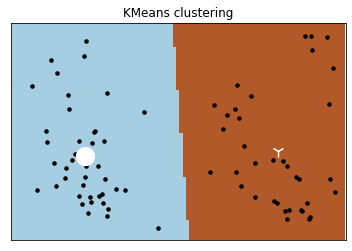

In [19]:
K = 2

# Let's do PCA for visualization
X_reduced, pca = get_pca_reduced(X_reshaped, dimensions=K)
X_clusters_reduced, kmeans_reduced = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced)

In [20]:
X_reshaped_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(to_cluster)

58900480/58889256 [==============================] - 0s 0us/step
[[2.9391393e-05 0.0000000e+00 8.4391279e-05 ... 0.0000000e+00
  3.5730498e-03 0.0000000e+00]
 [2.1105459e-05 0.0000000e+00 1.3241482e-04 ... 0.0000000e+00
  3.7398790e-03 0.0000000e+00]]
{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 42, 66, 69, 74]), 1: array([37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73,
       75, 76])}


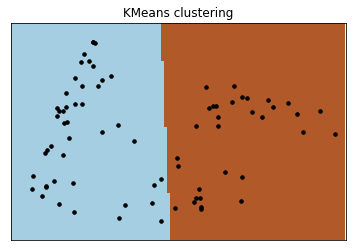

In [21]:
X_reduced_fm, pca_fm = get_pca_reduced(X_reshaped_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm)

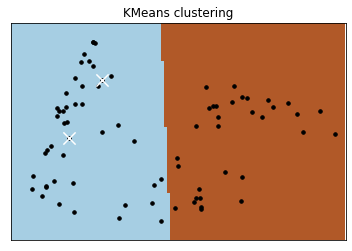

In [22]:
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm, idx=[0, 3])

In [23]:
def plot_scatter_clusters(X_reduced, Y):
  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap="Paired")
  plt.colorbar()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


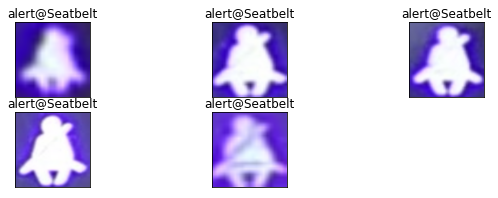

In [25]:
to_cluster_Y = np.concatenate((box_labels[idx_a_seatbelt], box_labels[idx_a_parking]))
plot_label_images(to_cluster[0:5], to_cluster_Y[0:5])


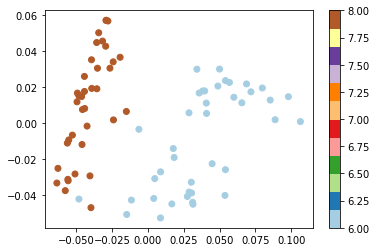

In [26]:
plot_scatter_clusters(X_reduced_fm, to_cluster_Y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


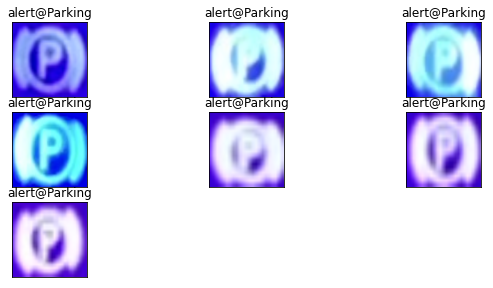

In [27]:
plot_label_images(to_cluster[70:78], to_cluster_Y[70:78])


# Cluster all labels

In [28]:
K = 15
X_reshaped_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(box_images, K=15)

[[1.6025895e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  3.3075698e-03 0.0000000e+00]
 [3.4734403e-06 0.0000000e+00 8.1603459e-05 ... 0.0000000e+00
  3.5032292e-03 0.0000000e+00]
 [7.6534183e-05 0.0000000e+00 5.5453529e-05 ... 0.0000000e+00
  3.5172545e-03 0.0000000e+00]
 ...
 [5.1759573e-04 0.0000000e+00 7.3808224e-06 ... 0.0000000e+00
  3.2754678e-03 0.0000000e+00]
 [4.9152656e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  3.3862684e-03 0.0000000e+00]
 [5.8335696e-05 0.0000000e+00 1.0934480e-05 ... 0.0000000e+00
  3.4099338e-03 0.0000000e+00]]
{0: array([  3,   7,  12,  16,  17,  18,  19,  23,  26,  27,  28,  35,  36,
        39,  40,  46,  47,  49,  71,  72,  75, 116, 120, 132, 136, 144,
       187, 189, 191, 198, 204, 213, 221, 222, 229, 230, 240, 252, 284,
       285, 320]), 1: array([  4,   5,   9,  11,  30,  44,  54,  56,  57,  88,  91,  93, 102,
       109, 126, 127, 131, 247, 249, 267, 268, 270, 272, 311, 314, 316]), 2: array([  8,  13,  50,  66,  70,  73,  74,  76

In [29]:
X_reduced_fm, pca_fm = get_pca_reduced(X_reshaped_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
# plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm)

In [30]:
X_reduced_fm.shape

(323, 15)

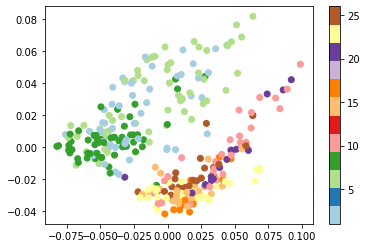

In [31]:
plot_scatter_clusters(X_reduced_fm, box_labels)

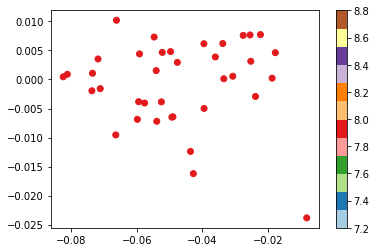

In [52]:
plot_scatter_clusters(X_reduced_fm[idx_a_seatbelt], box_labels[idx_a_seatbelt])

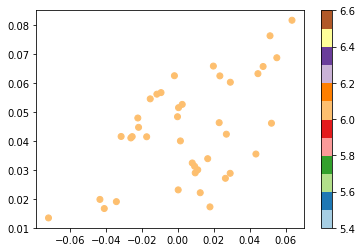

In [53]:
plot_scatter_clusters(X_reduced_fm[idx_a_parking], box_labels[idx_a_parking])

# Appendix

In [32]:
idx_a_seatbelt = np.where(CLASS_NAMES.index('alert@Seatbelt') == box_labels)
idx_a_parking = np.where(CLASS_NAMES.index('alert@Parking') == box_labels)
idx_w_engine = np.where(CLASS_NAMES.index('warning@Engine') == box_labels)

In [33]:
to_plot_X = np.concatenate((X_reduced_fm[idx_a_seatbelt], X_reduced_fm[idx_a_parking], X_reduced_fm[idx_w_engine]))
to_plot_Y = np.concatenate((box_labels[idx_a_seatbelt], box_labels[idx_a_parking], box_labels[idx_w_engine]))
to_plot_X.shape

(103, 15)

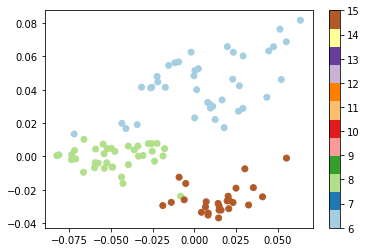

In [34]:
plot_scatter_clusters(to_plot_X, to_plot_Y)

In [40]:
def get_label_idx(labels, subset):
  idx_labels = []
  sub_labels = []
  for label in subset:
    # print(label, np.where(CLASS_NAMES.index(label) == labels)[0])
    idx = np.where(CLASS_NAMES.index(label) == labels)[0]
    idx_labels.extend(idx)

    sub_labels.extend([CLASS_NAMES.index(label) for i in range(len(idx))])

  return np.array(idx_labels), np.array(sub_labels)

box_idx_top5, box_labels_top5 = get_label_idx(box_labels, DB_TOP5)
# box_idx_top5_n, box_labels_top5_n = get_label_idx(box_labels, TOP5, is_in=False)

print(box_idx_top5, box_labels_top5)

[  5  25  29  41  54  73  77  93 109 113 131 156 159 160 163 164 170 172
 176 194 200 212 223 249 254 267 268 270 272 273 276 278 280 289 311 316
 322   1  16  48  63  67 100 121 135 144 182 187 215 217 239 264 269 271
 274 275 277 279 282 310 312 319 320  15  45  64  68  95 103 118 129 151
 153 154 155 157 158 161 162 165 166 167 168 169 171 177 178 179 181 183
 184 195 216 219 238 266 286 287 291 292 314 315 317   3  23  36  39  60
  80  86 101 111 125 137 140 198 206 235 244 252 259 285 294 302 308   0
  21  33  37  58  79  84  89 108 134 142 175 192 203 208 227 233 246 250
 261 283 295 301 304] [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 23 23 23 23 2

In [41]:
box_labels_top5.shape

(149,)

In [42]:
box_labels.shape

(323,)

In [43]:
box_idx_top5_n = [id not in box_idx_top5 for id in range(len(box_labels))]

In [44]:
box_labels[box_idx_top5_n] = 0

In [45]:
box_labels

array([23, 15,  0, 26,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 15,
        0,  0,  0,  0, 23,  0, 26,  0,  8,  0,  0,  0,  8,  0,  0,  0, 23,
        0,  0, 26, 23,  0, 26,  0,  8,  0,  0,  0,  6,  0,  0, 15,  0,  0,
        0,  0,  0,  8,  0,  0,  0, 23,  0, 26,  0,  0, 15,  6,  0,  0, 15,
        6,  0,  0,  0,  0,  8,  0,  0,  0,  8,  0, 23, 26,  0,  0,  0, 23,
        0, 26,  0,  0, 23,  0,  0,  0,  8,  0,  6,  0,  0,  0,  0, 15, 26,
        0,  6,  0,  0,  0,  0, 23,  8,  0, 26,  0,  8,  0,  0,  0,  0,  6,
        0,  0, 15,  0,  0,  0, 26,  0,  0,  0,  6,  0,  8,  0,  0, 23, 15,
        0, 26,  0,  0, 26,  0, 23,  0, 15,  0,  0,  0,  0,  0,  0,  6,  0,
        6,  6,  6,  8,  6,  6,  8,  8,  6,  6,  8,  8,  6,  6,  6,  6,  6,
        8,  6,  8,  0,  0, 23,  8,  6,  6,  6,  0,  6, 15,  6,  6,  0,  0,
       15,  0,  0,  0,  0, 23,  0,  8,  6,  0,  0, 26,  0,  8,  0,  0, 23,
        0,  0, 26,  0, 23,  0,  0,  0,  8,  0,  0, 15,  6, 15,  0,  6,  0,
        0,  0,  8,  0,  0

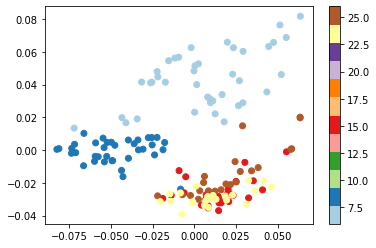

In [46]:
plot_scatter_clusters(X_reduced_fm[box_idx_top5], box_labels_top5)

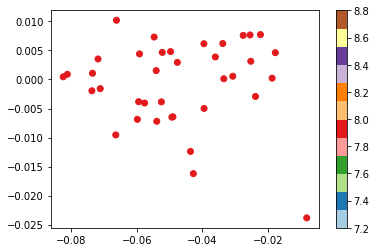

In [54]:
plot_scatter_clusters(X_reduced_fm[idx_a_seatbelt], box_labels[idx_a_seatbelt])

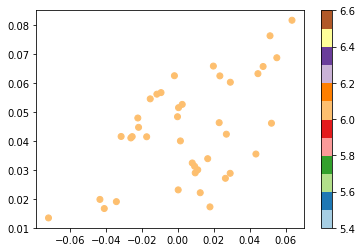

In [55]:
plot_scatter_clusters(X_reduced_fm[idx_a_parking], box_labels[idx_a_parking])

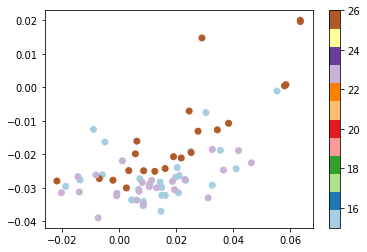

In [87]:
def plot_scatter_per_labels(X_reduced, box_labels, labels_to_plot):
  idx_to_plot = []
  for label_to_plot in labels_to_plot:
    idx_to_plot += np.where(CLASS_NAMES.index(label_to_plot) == box_labels)[0].tolist()

  plot_scatter_clusters(X_reduced[idx_to_plot], box_labels[idx_to_plot])

plot_scatter_per_labels(X_reduced_fm, box_labels, ['warning@Engine', 'warning@Tire', 'warning@StabilityOn'])

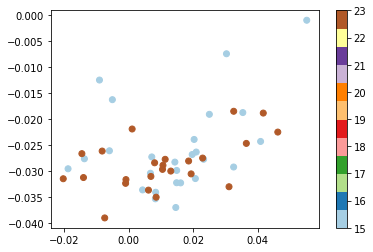

In [88]:
plot_scatter_per_labels(X_reduced_fm, box_labels, ['warning@Engine', 'warning@StabilityOn'])


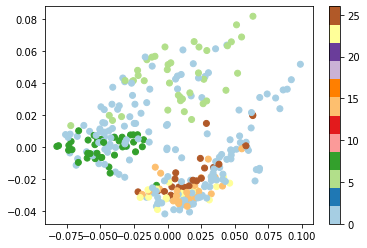

In [47]:
plot_scatter_clusters(X_reduced_fm, box_labels)

In [49]:
 [(label, CLASS_NAMES.index(label)) for label in DB_TOP5]

[('alert@Seatbelt', 8),
 ('warning@Engine', 15),
 ('alert@Parking', 6),
 ('warning@Tire', 26),
 ('warning@StabilityOn', 23)]

In [50]:
box_idx_top5

array([  5,  25,  29,  41,  54,  73,  77,  93, 109, 113, 131, 156, 159,
       160, 163, 164, 170, 172, 176, 194, 200, 212, 223, 249, 254, 267,
       268, 270, 272, 273, 276, 278, 280, 289, 311, 316, 322,   1,  16,
        48,  63,  67, 100, 121, 135, 144, 182, 187, 215, 217, 239, 264,
       269, 271, 274, 275, 277, 279, 282, 310, 312, 319, 320,  15,  45,
        64,  68,  95, 103, 118, 129, 151, 153, 154, 155, 157, 158, 161,
       162, 165, 166, 167, 168, 169, 171, 177, 178, 179, 181, 183, 184,
       195, 216, 219, 238, 266, 286, 287, 291, 292, 314, 315, 317,   3,
        23,  36,  39,  60,  80,  86, 101, 111, 125, 137, 140, 198, 206,
       235, 244, 252, 259, 285, 294, 302, 308,   0,  21,  33,  37,  58,
        79,  84,  89, 108, 134, 142, 175, 192, 203, 208, 227, 233, 246,
       250, 261, 283, 295, 301, 304])